# **Wikipedia Project**

#### Alunos:


*   Lyndon Jonhson Cabral Filho
*   Rafael Pinheiro Carlos Maia

## 0. Importando Bibliotecas



In [1]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=ba0f60bf7df123027495010475579f65544d8054c36576e66a22159ea6805421
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [2]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

## 1. Pipeline de Dados

### 1.1 Coleta dos dados

Para o projeto utilizamos um livro do Stephen King, Sob a Redoma (Under The Dome).

In [3]:
def criar_grafo(SEED, STOPS):
  todo_lst = [(0, SEED)] # The SEED is in the layer 0
  todo_set = set(SEED) # The SEED itself
  done_set = set() # Nothing is done yet

  g = nx.DiGraph()
  layer, page = todo_lst[0]

  while layer < 2:
    # Remove the name page of the current page from the todo_lst,
    # and add it to the set of processed pages.
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)

    # Show progress
    print(layer, page)

    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print("Could not load", page)
      layer, page = todo_lst[0]
      continue

    for link in wiki.links:
      link = link.title()
      if link not in STOPS and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  print("Número de Nós: {}".format(len(g)))
  print("Número de Links: {}".format(nx.number_of_edges(g)))

  return g

### 1.2 Pré-processamento

Etapa necessária para remover as duplicatas presentes no dataset.

In [4]:
def pre_processamento(g):
  # make a copy of raw graph
  original = g.copy()

  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s")
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  print(duplicates)

  duplicates = [(x, y) for x, y in
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]
  print(duplicates)

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  print("Número de Nós: {}".format(len(g)))
  print("Número de Links: {}".format(nx.number_of_edges(g)))

  return g

### 1.3 Truncamento da Rede

Nessa etapa nós removemos os nós de grau inferior a 4.

In [5]:
def plot_histograma(g):
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

  fig, ax = plt.subplots(1,1,figsize=(8,4))

  ax.hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax.set_title("Degree Histogram")
  ax.set_ylabel("Count")
  ax.set_xlabel("Degree")

  plt.show()

In [6]:
def truncar(g):
  plot_histograma(g)

  # filter nodes with degree greater than or equal to 4
  core = [node for node, deg in dict(g.degree()).items() if deg >= 4]

  # select a subgraph with 'core' nodes
  g2 = nx.subgraph(g, core)

  print("Número de Nós: {}".format(len(g2)))
  print("Número de Links: {}".format(nx.number_of_edges(g2)))

  nx.write_graphml(g2, "cna.graphml")

  print("Nós removidos: {:.2f}%".format(100*(1 - len(g2)/len(g))))
  print("Links removidos: {:.2f}%".format(100*(1 - nx.number_of_edges(g2)/nx.number_of_edges(g))))
  print("Links por nós: {:.2f}".format(nx.number_of_edges(g2)/len(g2)))

  plot_histograma(g2)

  return g2

### 1.4 Explorando a Rede

#### Centralidade

In [7]:
def plot_centralidade(g2):
  fig, ax = plt.subplots(2,2,figsize=(16,14))

  # max value of metrics
  max_centrality = max([max([v for k, v in nx.eigenvector_centrality(g2).items()]),
                        max([v for k, v in nx.degree_centrality(g2).items()]),
                        max([v for k, v in nx.closeness_centrality(g2).items()]),
                        max([v for k, v in nx.betweenness_centrality(g2).items()])])

  # layout position
  pos = nx.spring_layout(g2,seed=123456789,k=0.3)

  # color of nodes
  color_degree = list(dict(nx.degree_centrality(g2)).values())
  color_closeness = list(dict(nx.closeness_centrality(g2)).values())
  color_betweenness = list(dict(nx.betweenness_centrality(g2)).values())
  color_eigenvector = list(dict(nx.eigenvector_centrality(g2)).values())

  #
  # draw edges
  #
  # degree centrality
  nx.draw_networkx_edges(g2,
                        pos=pos,
                        alpha=0.4, ax=ax[0,0])

  # closeness centrality
  nx.draw_networkx_edges(g2,
                        pos=pos,
                        alpha=0.4, ax=ax[0,1])

  # betweenness centrality
  nx.draw_networkx_edges(g2,
                        pos=pos,
                        alpha=0.4, ax=ax[1,0])

  # eigenvector centrality
  nx.draw_networkx_edges(g2,
                        pos=pos,
                        alpha=0.4, ax=ax[1,1])

  # draw nodes
  nodes = nx.draw_networkx_nodes(g2,
                  pos=pos,
                  node_color=color_degree,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,0])
  nodes = nx.draw_networkx_nodes(g2,
                  pos=pos,
                  node_color=color_closeness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[0,1])
  nodes = nx.draw_networkx_nodes(g2,
                  pos=pos,
                  node_color=color_betweenness,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,0])
  nodes = nx.draw_networkx_nodes(g2,
                  pos=pos,
                  node_color=color_eigenvector,
                  cmap=plt.cm.jet,vmin=0,vmax=max_centrality,
                  ax=ax[1,1])

  #
  # draw labels
  #
  nx.draw_networkx_labels(g2, pos=pos,
                          font_color='black', ax=ax[0,0])
  nx.draw_networkx_labels(g2, pos=pos,
                          font_color='black', ax=ax[0,1])
  nx.draw_networkx_labels(g2, pos=pos,
                          font_color='black', ax=ax[1,0])
  nx.draw_networkx_labels(g2, pos=pos,
                          font_color='black', ax=ax[1,1])

  # eliminate axis
  ax[0,0].axis("off")
  ax[1,0].axis("off")
  ax[0,1].axis("off")
  ax[1,1].axis("off")

  ax[0,0].set_title("Degree Centrality")
  ax[0,1].set_title("Closeness Centrality")
  ax[1,0].set_title("Betweenness Centrality")
  ax[1,1].set_title("Eigenvector Centrality")

  plt.subplots_adjust(bottom=0., right=0.92, top=1.)
  cax = plt.axes([0.95, 0.3, 0.025, 0.4])
  sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(vmin=0, vmax=max_centrality))
  cbar=plt.colorbar(sm,cax)

  plt.savefig('alltogether.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [8]:
def plot_dist_centralidade(g2):
  degree_sequence = sorted([d for n, d in g2.degree()], reverse=True)

  fig, ax = plt.subplots(1,2,figsize=(8,6))

  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.show()

  plt.style.use("fivethirtyeight")

  fig, ax = plt.subplots(1,1,figsize=(10,8))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  bc = pd.Series(nx.betweenness_centrality(g2))
  dc = pd.Series(nx.degree_centrality(g2))
  ec = pd.Series(nx.eigenvector_centrality(g2))
  cc = pd.Series(nx.closeness_centrality(g2))

  df = pd.DataFrame.from_dict({"Betweenness": bc,
                              "Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df.reset_index(inplace=True,drop=True)
  df.head()

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()


#### Decomposição de Núcleo

In [9]:
def dec_nucleo(g2):
  print(set([v for k,v in nx.core_number(g2).items()]))

In [10]:
def plot_dec_nucleo(g2):
  # the degree of network(g2)
  fig, ax = plt.subplots(1,1,figsize=(10,8))

  # Find k-cores
  gplot_shell = nx.k_shell(g2, 153)
  gplot_core = nx.k_core(g2, 243)

  # layout position
  pos = nx.spring_layout(g2,seed=123456789,k=0.3)

  # draw edges
  nx.draw_networkx_edges(g2,
                        pos=pos,
                        alpha=0.4, ax=ax)

  # draw nodes
  nodes = nx.draw_networkx_nodes(g2,
                  pos=pos,
                  node_color="#333333")

  # draw nodes
  nodes = nx.draw_networkx_nodes(gplot_shell,
                  pos=pos,
                  node_color="blue")

  nodes = nx.draw_networkx_nodes(gplot_core,
                  pos=pos,
                  node_color="red")

  # static legend
  red_patch = mpatches.Patch(color='red', label='243-core')
  blue_patch = mpatches.Patch(color='blue', label='153-shell')
  plt.legend(handles=[red_patch,blue_patch])

  plt.axis("off")
  plt.savefig('k-core_sociopatterns.png', transparent=True,dpi=600)
  plt.show()

#### Explorar

In [11]:
def explorar_rede(g2):
  print("PLOT DA CENTRALIDADE")
  plot_centralidade(g2)
  print("DEGREE CENTRALITY")
  print(nx.degree_centrality(g2))
  print("CLOSENESS CENTRALITY")
  print(nx.closeness_centrality(g2))
  print("BETWEENNESS CENTRALITY")
  print(nx.betweenness_centrality(g2))
  print("EIGENVECTOR CENTRALITY")
  print(nx.eigenvector_centrality(g2))
  print("PLOT DA DISTRIBUIÇÃO DE CENTRALIDADE")
  plot_dist_centralidade(g2)
  print("DECOMPOSIÇÃO DO NÚCLEO")
  dec_nucleo(g2)
  print("PLOT DA DECOMPOSIÇÃO DO NÚCLEO")
  plot_dec_nucleo(g2)

## 2. Utilizando o Pipeline

In [12]:
# https://en.wikipedia.org/wiki/Under_the_Dome_(novel)
SEED = "Under the Dome (Novel)".title()
STOPS = ("International Standard Name Identifier",
        "Viaf (Identifier)",
        "Isni (Identifier)",
        "Isbn (Identifier)",
        "Stephen King",
        "Under the dome")

In [13]:
g = criar_grafo(SEED, STOPS)

0 Under The Dome (Novel)
1 'Salem'S Lot
1 11/22/63
1 A Good Marriage (Film)
1 Aide-De-Camp
1 All-World
1 Allegory
1 Alternate Reality Game
1 Amazon.Com
1 American Vampire
1 Amy Chozick
1 Animal Farm
Could not load Animal Farm
1 Ant Farm
Could not load Ant Farm
1 Asphyxia
1 Associated Press
1 Bag Of Bones
1 Barnes & Noble
1 Bibliography Of Works On Stephen King
1 Billy Summers
1 Black House (Novel)
1 Black Ribbons
1 Blaze (Novel)
1 Blue On Blue (Under The Dome)
1 Book Tv
1 Brain Tumor
1 Brevet (Military)
1 Brian K. Vaughan
Could not load Brian K. Vaughan
1 Bridgton, Maine
1 C-Span
1 Cbs


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Cbs
1 Carrie (Novel)
1 Castle Rock (Stephen King)
1 Castle Rock Entertainment
1 Cat'S Eye (1985 Film)
1 Cell (Film)
1 Cell (Novel)
1 Charles Scribner'S Sons
1 Charlie The Choo-Choo (Book)
1 Chinga (The X-Files)
1 Christine (Novel)
1 Creepshow
1 Cujo
Could not load Cujo
1 Curtains (Under The Dome)
1 Cycle Of The Werewolf
1 Dan Simmons
Could not load Dan Simmons
1 Danse Macabre (Book)
1 Derry (Stephen King)
1 Desperation (Novel)
1 Diabolus Ex Machina
1 Dick Cheney
1 Different Seasons
1 Disembowel
1 Doctor Sleep (Novel)
1 Dollar Baby
1 Dolores Claiborne
1 Dome
1 Domed City
Could not load Domed City
1 Douglas E. Winter
1 Dreamworks Television
1 Dreamcatcher (Novel)
1 Duma Key
1 Dust Jacket
Could not load Dust Jacket
1 Elevation (Novella)
1 End Of Watch (Novel)
1 Endpaper
1 Entertainment Weekly
1 Everything'S Eventual
1 Exigent Circumstances (Under The Dome)
1 Extraterrestrial Life
1 Facsimile
1 Fairy Tale (Novel)
1 Faithful (Book)
1 Fallout Shelter
Could not load Fallout She

In [14]:
g = pre_processamento(g)

[('Hallucination', 'Hallucinations'), ('Primetime Emmy Award', 'Primetime Emmy Awards'), ('Secret Window', 'Secret Windows'), ('Aiguillette', 'Aiguillettes'), ('Governor', 'Governors'), ('Lieutenant', 'Lieutenants'), ('Nuclear Weapon', 'Nuclear Weapons'), ('Post-Nominal Letter', 'Post-Nominal Letters'), ('Audio-Animatronic', 'Audio-Animatronics'), ('Blue', 'Blues'), ('Characterization', 'Characterizations'), ('Fairy Tale', 'Fairy Tales'), ('America', 'Americas'), ('Blog', 'Blogs'), ('Cooperative', 'Cooperatives'), ('Exit Poll', 'Exit Polls'), ('Style Guide', 'Style Guides'), ('A&E Network', 'A&E Networks'), ('Audiobook', 'Audiobooks'), ('Ghost', 'Ghosts'), ('Cd', 'Cds'), ('Horror Film', 'Horror Films'), ('Anticonvulsant', 'Anticonvulsants'), ('Astrocyte', 'Astrocytes'), ('Glioma', 'Gliomas'), ('Headache', 'Headaches'), ('Meningioma', 'Meningiomas'), ('Nerve Sheath Tumor', 'Nerve Sheath Tumors'), ('Neuron', 'Neurons'), ('Oligodendrocyte', 'Oligodendrocytes'), ('Pituitary Adenoma', 'Pitu

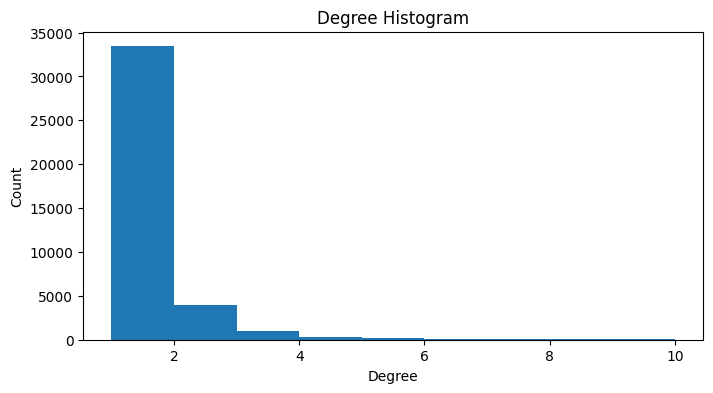

Número de Nós: 1198
Número de Links: 26795
Nós removidos: 96.97%
Links removidos: 62.30%
Links por nós: 22.37


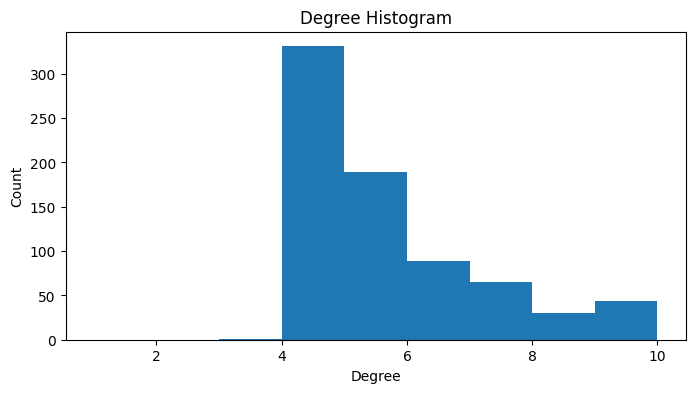

In [15]:
g = truncar(g)

PLOT DA CENTRALIDADE


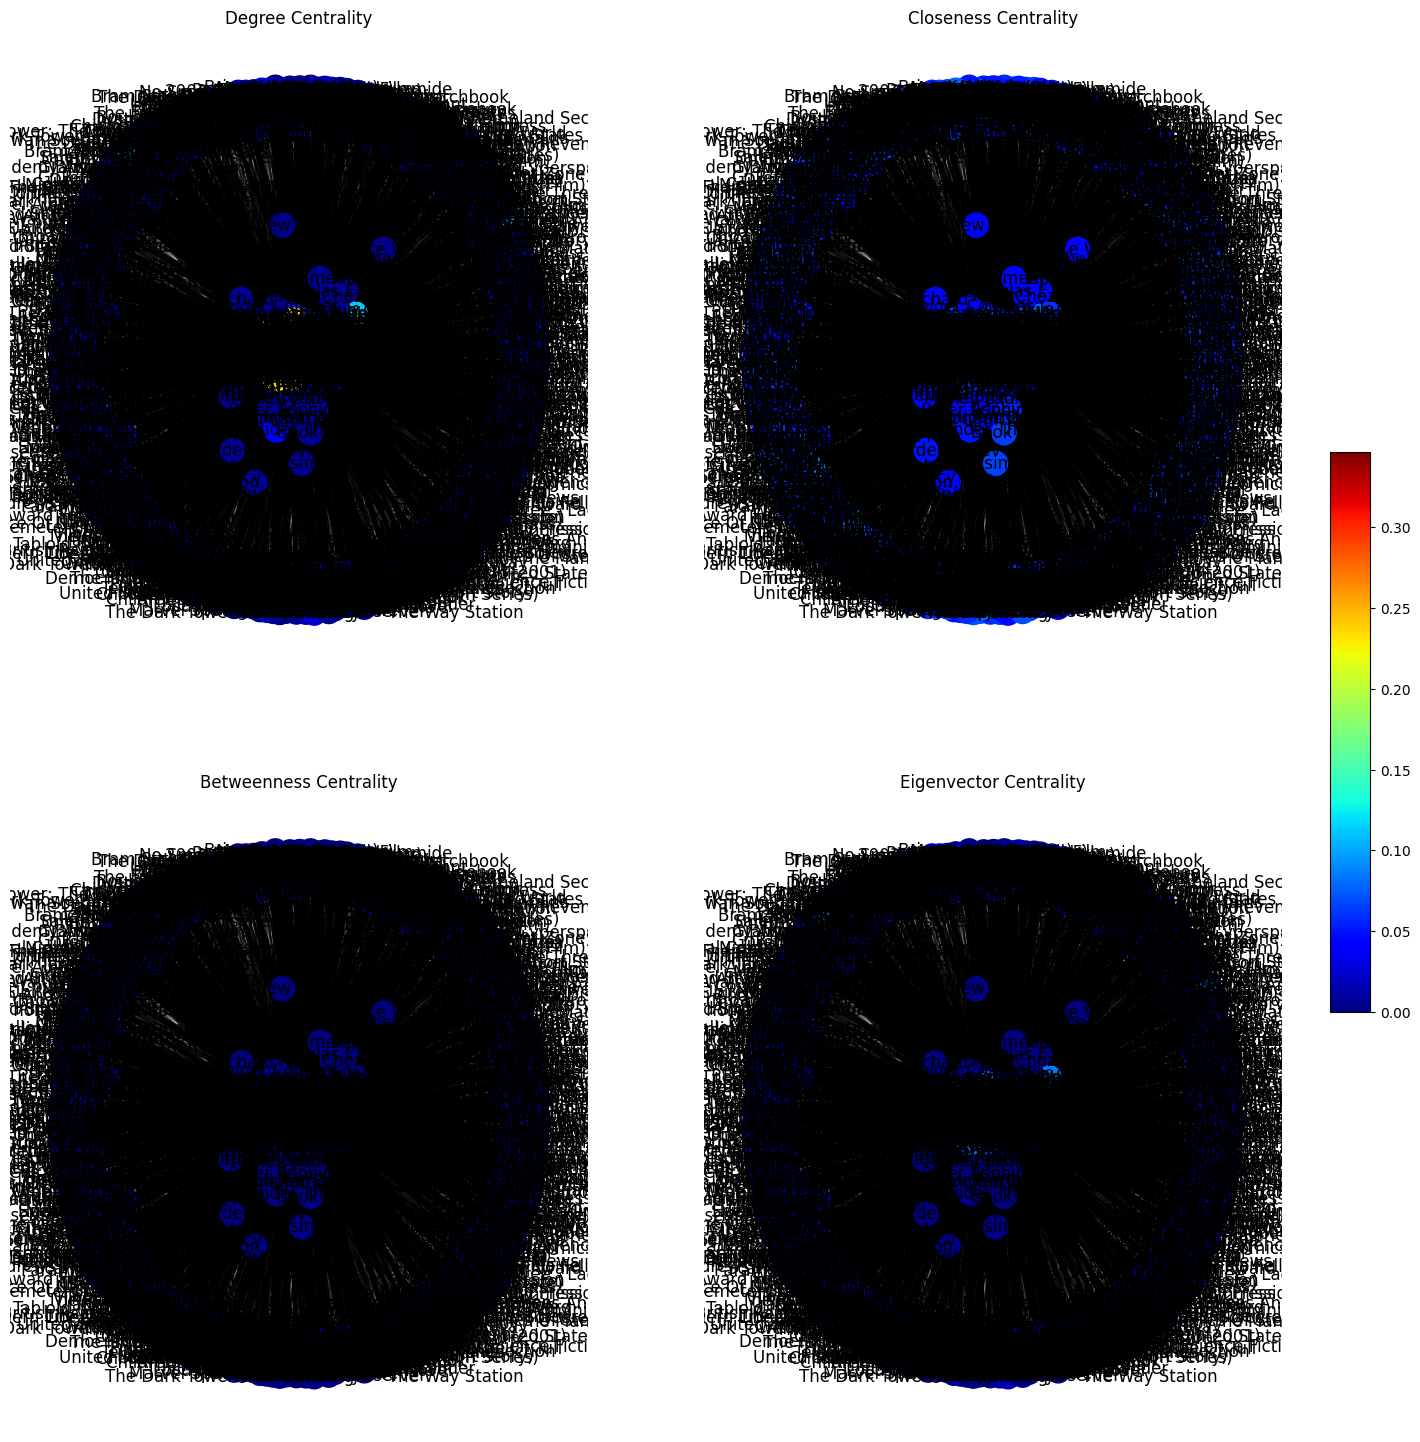

DEGREE CENTRALITY
{'Thomas Piccirilli': 0.004177109440267335, 'Bill Clinton': 0.005012531328320802, 'American Literature': 0.004177109440267335, 'Colin Ford': 0.011695906432748537, 'President (Corporate Title)': 0.003341687552213868, 'Paramount+': 0.005847953216374269, 'Africa': 0.003341687552213868, 'Elevation (Novella)': 0.22305764411027568, "Salem'S Lot (2004 Miniseries)": 0.01670843776106934, 'Stephen King Goes To The Movies': 0.227234753550543, 'Soviet Union': 0.005847953216374269, 'Richard Nixon': 0.003341687552213868, 'Bibliography Of Works On Stephen King': 0.27401837928153716, 'Office Of National Drug Control Policy': 0.004177109440267335, 'Warner Bros. Television': 0.003341687552213868, 'The Village Voice': 0.004177109440267335, 'Scott Snyder': 0.004177109440267335, 'Indonesia': 0.003341687552213868, 'Georgia (U.S. State)': 0.003341687552213868, 'Europe': 0.003341687552213868, 'Amazon.Com': 0.06766917293233082, 'Omni (Magazine)': 0.003341687552213868, 'Peer Pressure': 0.01754

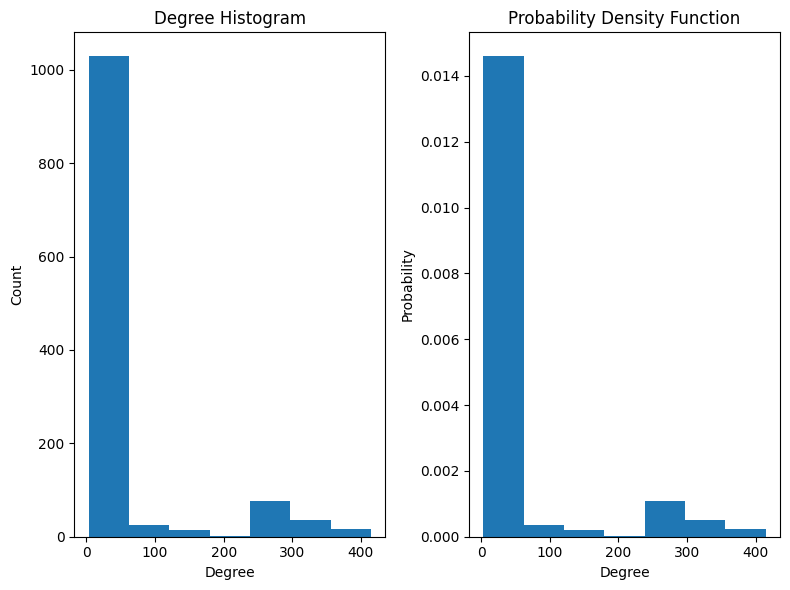

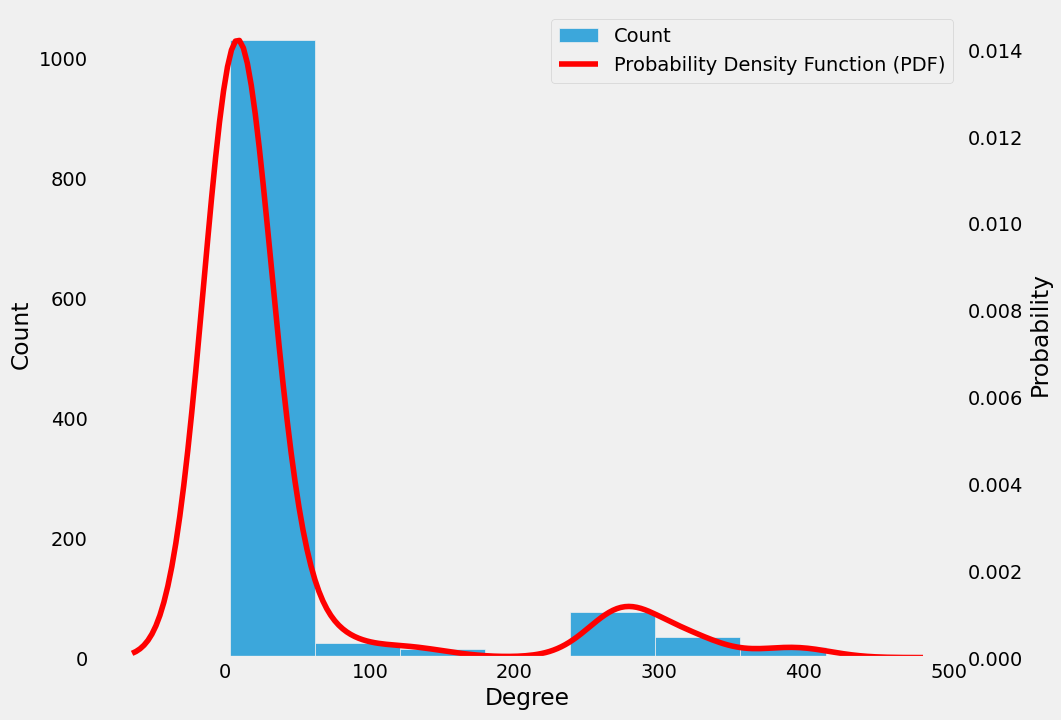

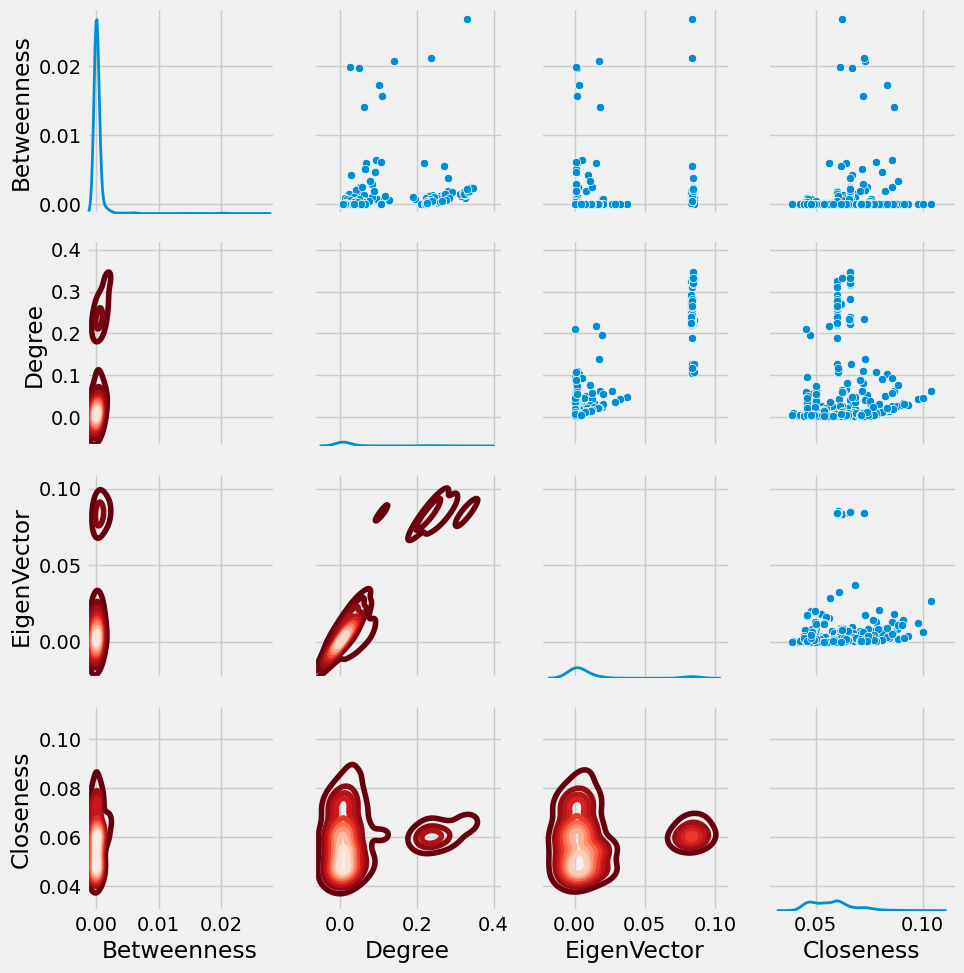

DECOMPOSIÇÃO DO NÚCLEO
{128, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 144, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 154, 29, 30, 32, 31, 34, 39, 40, 41, 44, 45, 49, 55, 245, 126, 127}
PLOT DA DECOMPOSIÇÃO DO NÚCLEO


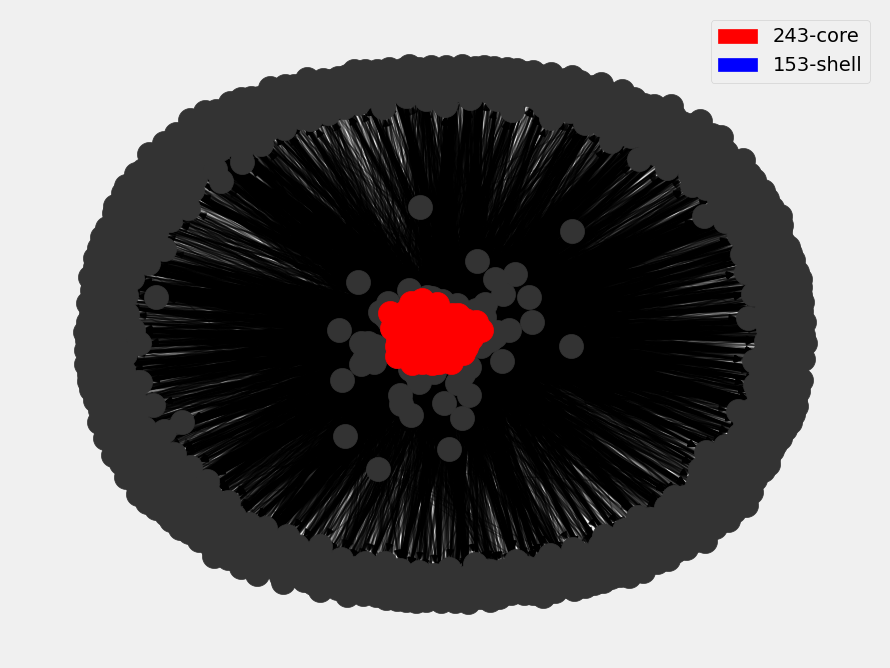

In [16]:
explorar_rede(g)